# Engram Neural Network

In [1]:
%pip install tensorflow numpy matplotlib pandas seaborn scipy keras statsmodels graphviz pydot -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from IPython.display import Image
from time import perf_counter as perf_time
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow_engram.layers import Engram
from tensorflow_engram.models import engram_classifier
from tensorflow_engram.utils import HebbianTraceMonitor, plot_hebbian_trace

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

np.random.seed(42)
tf.random.set_seed(42)

2025-05-20 18:09:09.049744: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 18:09:09.053195: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 18:09:09.063065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747764549.077466  110899 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747764549.081912  110899 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747764549.094640  110899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Preprocess the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
scaler = MinMaxScaler()
x_train = x_train.reshape(-1, 28 * 28).astype(np.float32) / 255.0  # Normalize to [0,1] range
x_test = x_test.reshape(-1, 28 * 28).astype(np.float32) / 255.0

# Apply scaler for additional normalization
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Reshape the data back to 28x28 for time steps (treating each row as a time step)
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (54000, 28, 28)
Validation data shape: (6000, 28, 28)
Test data shape: (10000, 28, 28)


2025-05-20 18:09:12.432879: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ engram (Engram)                 │ (None, 128)            │       217,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,018 (855.54 KB)

 Trainable params: 210,826 (823.54 KB)

 Non-trainable params: 8,192 (32.00 KB)

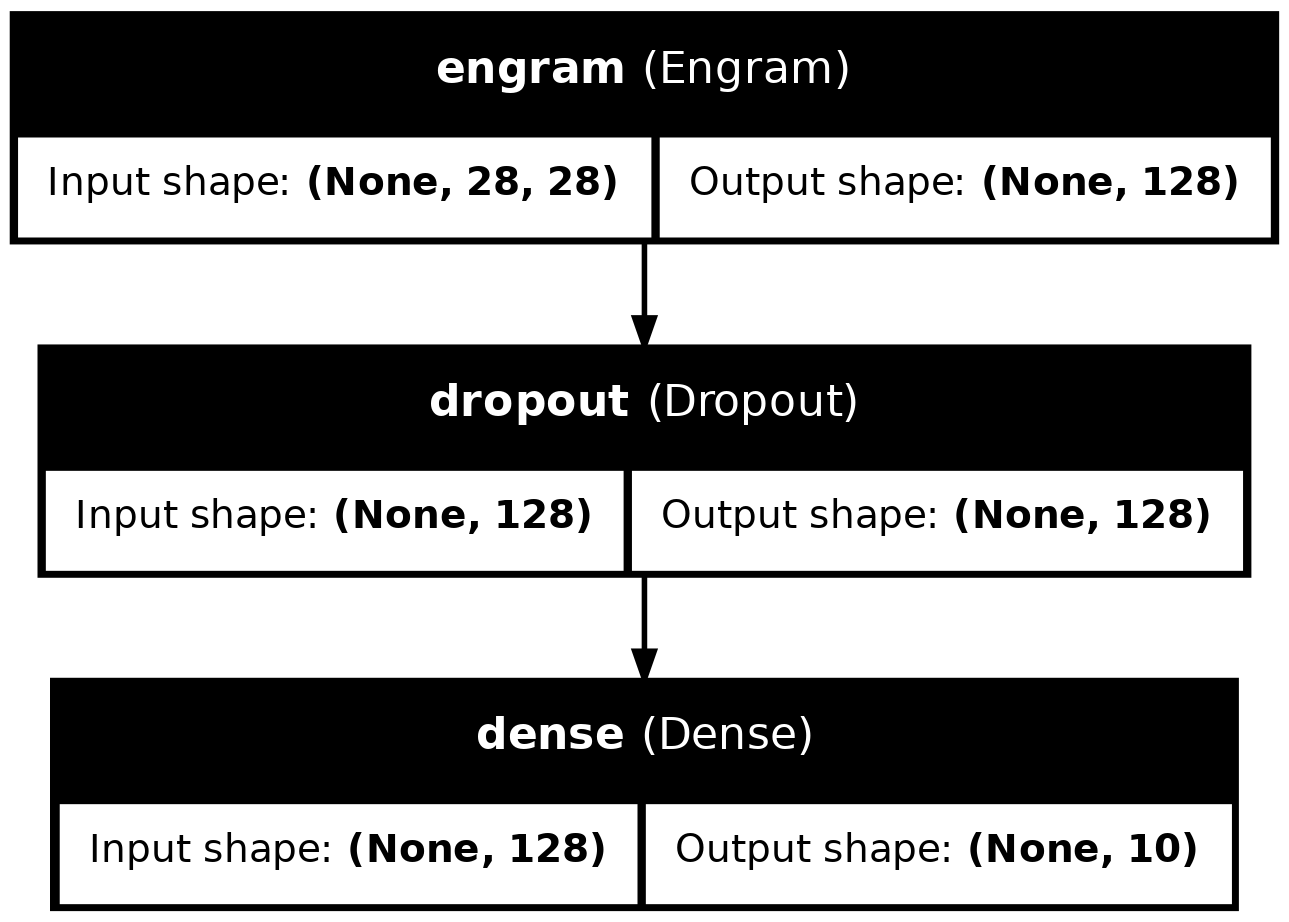

In [ ]:
# Create the MNIST classifier
mnist_model = engram_classifier(
    input_shape=(28, 28), # 28 time steps, each with 28 features
    hidden_dim=128,
    memory_size=64,  # Increased memory size
    num_classes=10,
    return_states=True,
    hebbian_lr=0.05  # Higher learning rate for Hebbian updates
)

trace_callback = HebbianTraceMonitor(
    x_train[:32], 
    log_dir="examples/out/hebbian_trace", 
    verbose=1, 
    plot_every=15, 
    skip_first_plot=True
)

# Create an early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Reduce learning rate when plateauing
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Compile and train the model
mnist_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
mnist_model.summary()
plot_model(mnist_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/mnist_model.png')
Image(filename='examples/out/mnist_model.png', width=800)

In [5]:
# mnist_model = keras.models.load_model('examples/out/mnist_model.h5', custom_objects={'HebbianTraceMonitor': HebbianTraceMonitor, 'Engram': Engram})

start_time = perf_time()
history = mnist_model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[trace_callback, early_stopping, lr_scheduler],
    verbose=1
)
duration = perf_time() - start_time
print(f"Training time: {duration:.2f} seconds")

np.save('examples/out/mnist_history.npy', history.history)
# history = np.load('examples/out/mnist_history.npy', allow_pickle=True).item()

HebbianTraceMonitor initialized.
Epoch 1/15


2025-05-20 18:09:12.817511: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3936 - loss: 1.6857
Hebbian trace [Epoch 1] - min: -0.0127, max: 0.0351, mean abs: 0.0049, sparsity: 91.13%
Saved Hebbian trace visualization to examples/out/hebbian_trace/hebbian_trace_epoch1_20250520-180952.png
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.3939 - loss: 1.6847 - val_accuracy: 0.7493 - val_loss: 0.7332 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7579 - loss: 0.7381
Hebbian trace [Epoch 2] - min: -0.0133, max: 0.0386, mean abs: 0.0045, sparsity: 92.22%
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.7580 - loss: 0.7379 - val_accuracy: 0.8110 - val_loss: 0.5493 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8106 - loss: 0.5808
Hebbian trace [Epoch 3] - min: -0.0134, max: 0.0383, mean abs: 0.0043, sparsity: 92.90%
422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.8106 - loss: 0.5808 - val_accuracy: 0.


Running evaluation on test data...
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9605 - loss: 0.1513
Test Loss: 0.1287, Test Accuracy: 0.9682
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


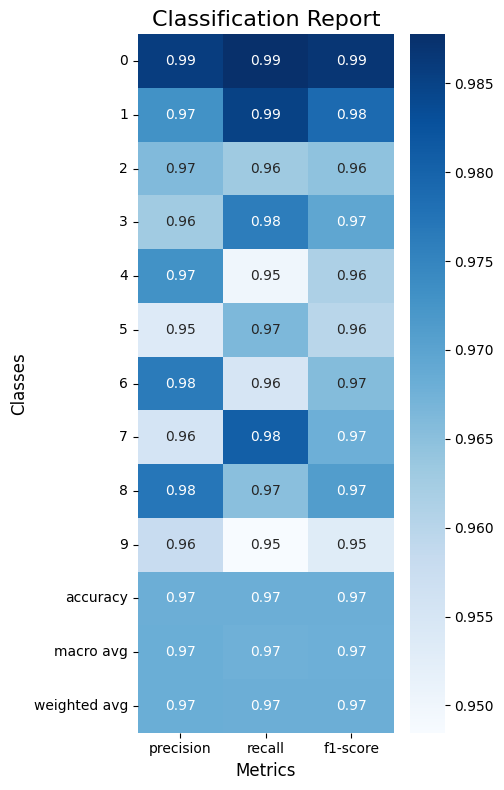

In [6]:
# Evaluate the model
print("\nRunning evaluation on test data...")
test_loss, test_acc = mnist_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Make predictions
y_pred = mnist_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)], output_dict=True)
df = pd.DataFrame(report)  #.transpose()
fig, ax = plt.subplots(figsize=(len(df)+1, 8))
sns.heatmap(df.iloc[:-1, :].T, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_title("Classification Report", fontsize=16)
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Classes", fontsize=12)
plt.tight_layout()
# plt.savefig('examples/out/classification_report.png')
plt.show()

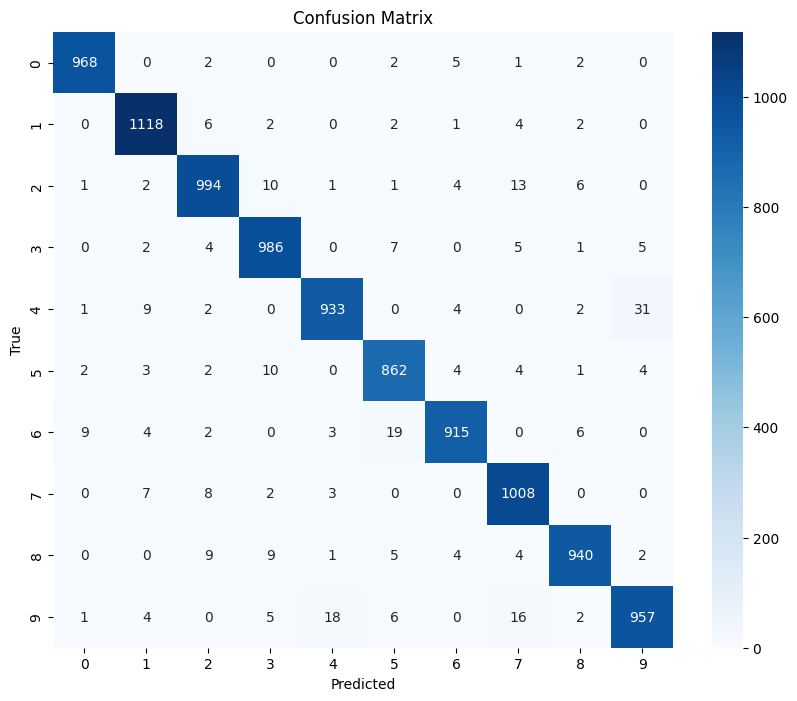

In [7]:
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('examples/out/confusion_matrix.png')
plt.show()

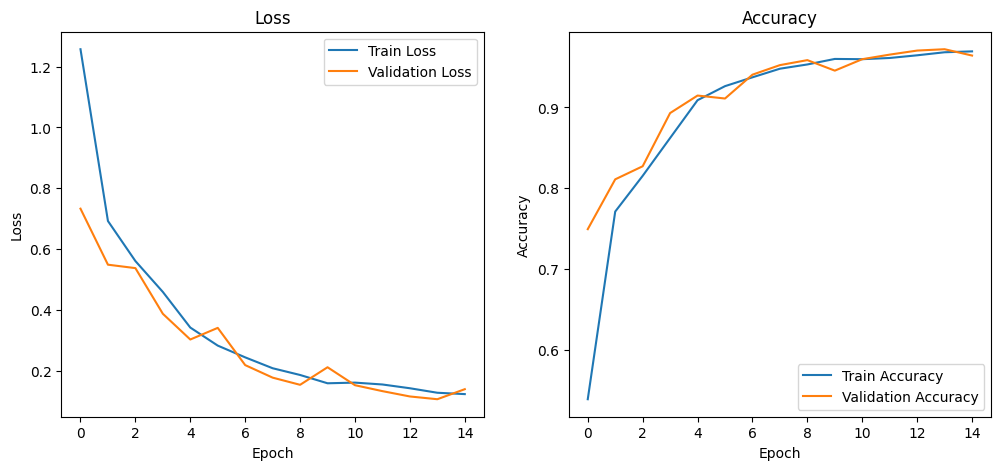

In [8]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('examples/out/training_history.png')
plt.show()

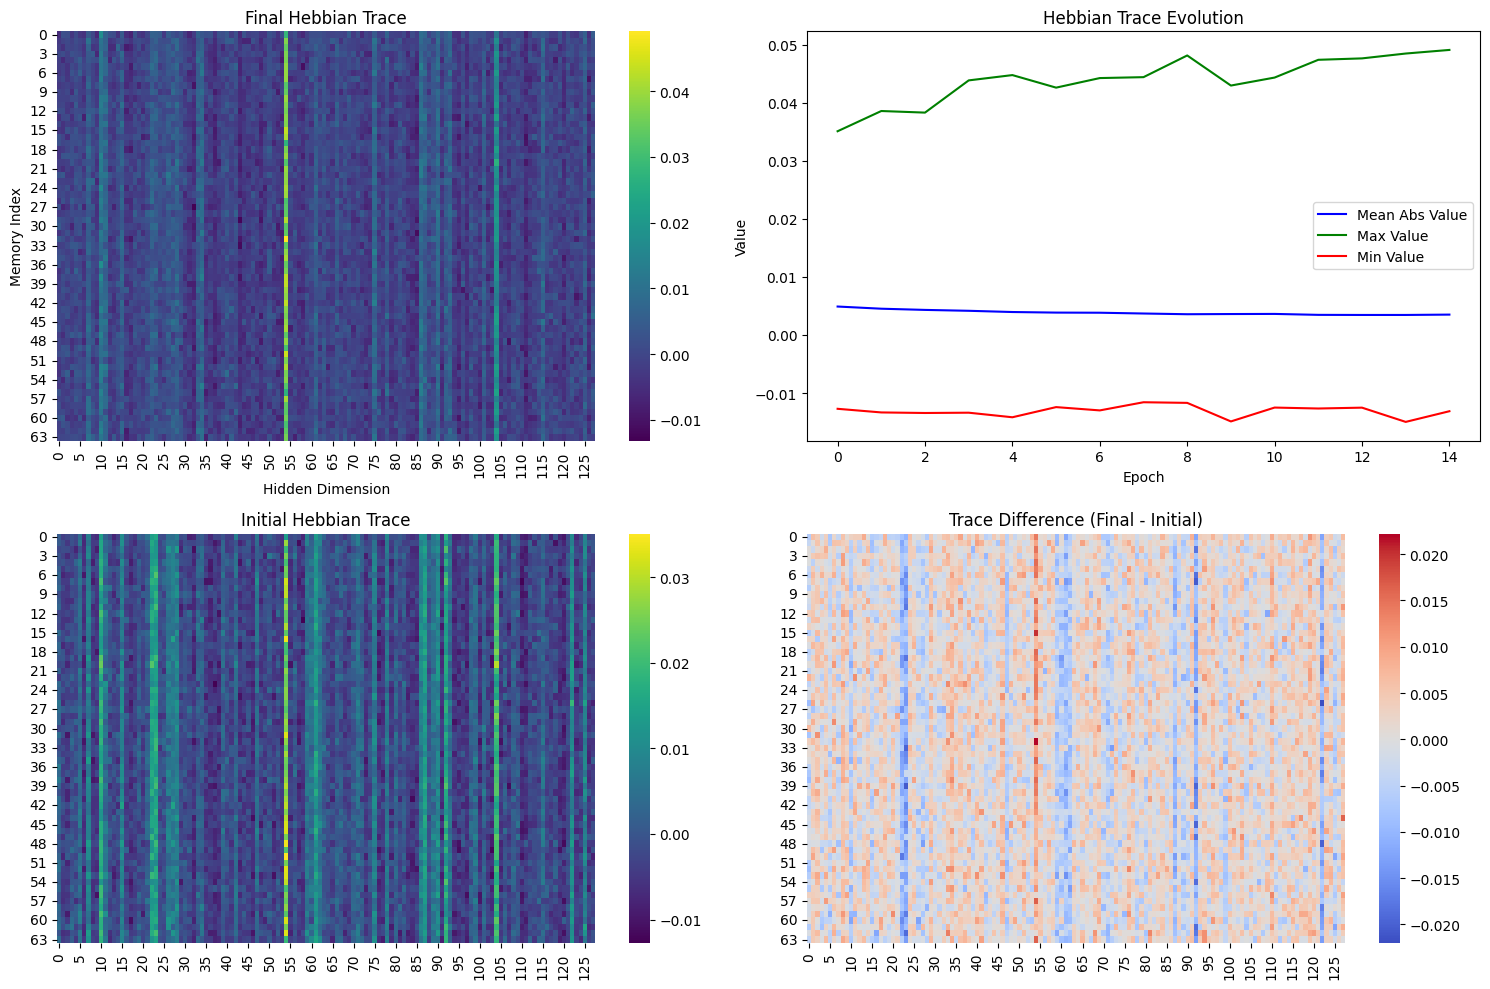

In [9]:
plot_hebbian_trace(trace_callback)  #, file_path='examples/out/hebbian_trace.png')
mnist_model.save('examples/out/mnist_model.h5')

# Model Comparison

## GRU

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 28, 128)        │        60,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,570 (385.04 KB)

 Trainable params: 98,570 (385.04 KB)

 Non-trainable params: 0 (0.00 B)

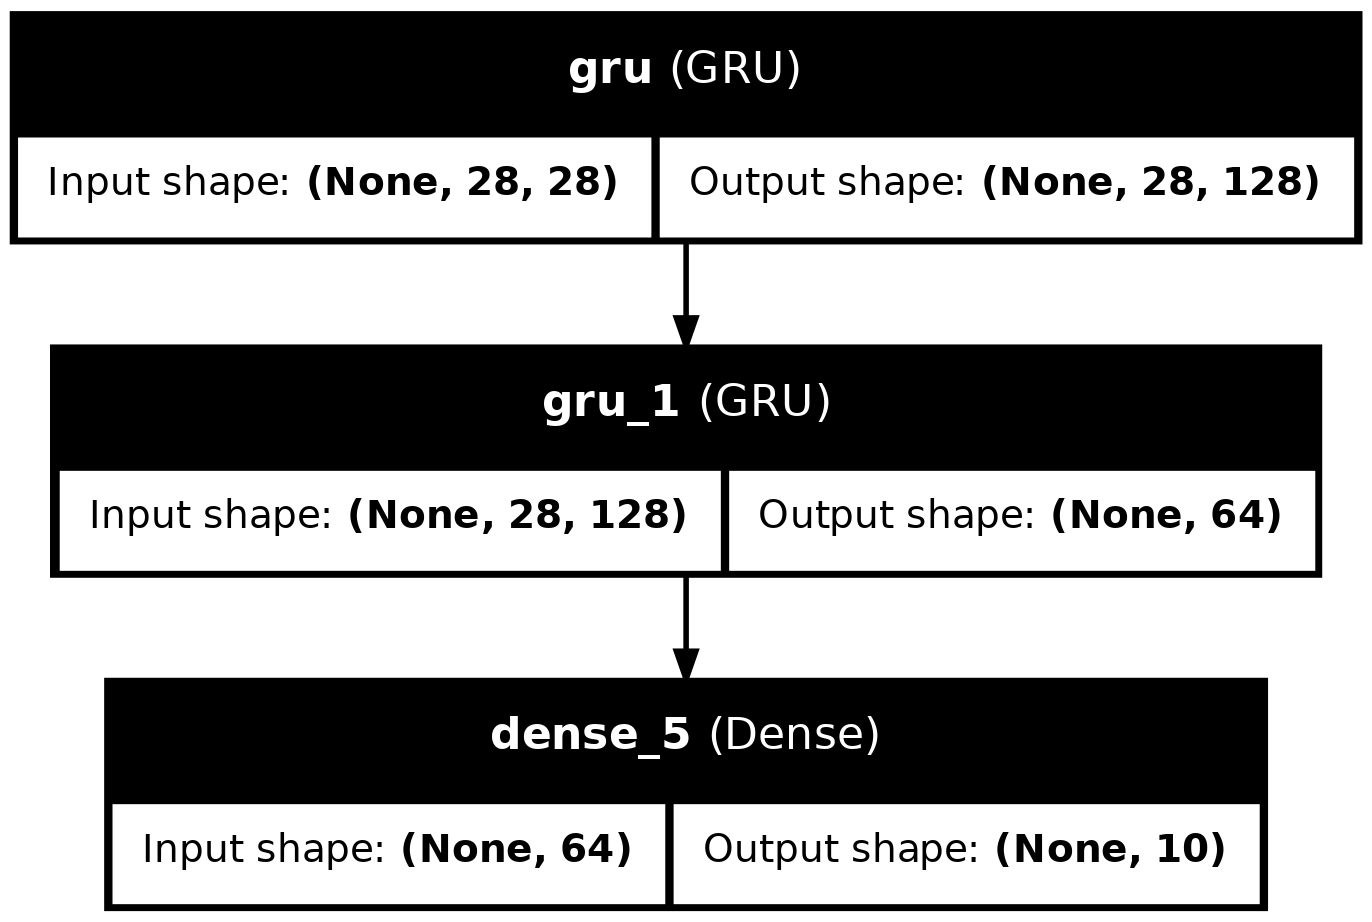

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Create a GRU model for comparison
gru_model = keras.Sequential([
    keras.layers.GRU(128, input_shape=(28, 28), return_sequences=True),
    keras.layers.GRU(64),
    keras.layers.Dense(10, activation='softmax')
])

# Compile and train the GRU model
gru_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
gru_model.summary()
plot_model(gru_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/gru_model.png')
Image(filename='examples/out/gru_model.png', width=800)

In [11]:
# gru_model = keras.models.load_model('examples/out/gru_model.h5')

start_time = perf_time()
history_gru = gru_model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)
duration = perf_time() - start_time
print(f"Training time: {duration:.2f} seconds")

np.save('examples/out/gru_history.npy', history_gru.history)
# history_gru = np.load('examples/out/gru_history.npy', allow_pickle=True).item()

Epoch 1/15


2025-05-20 18:18:42.431380: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.6357 - loss: 1.0337 - val_accuracy: 0.9405 - val_loss: 0.1879 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9522 - loss: 0.1617 - val_accuracy: 0.9643 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9717 - loss: 0.0947 - val_accuracy: 0.9782 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9790 - loss: 0.0688 - val_accuracy: 0.9808 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9832 - loss: 0.0550 - val_accuracy: 0.9822 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9867 - loss: 0.0441 - val_accuracy: 0.9843 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9891 - loss: 0.0365


Running evaluation on test data for GRU model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9859 - loss: 0.0483
Test Loss: 0.0368, Test Accuracy: 0.9898
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


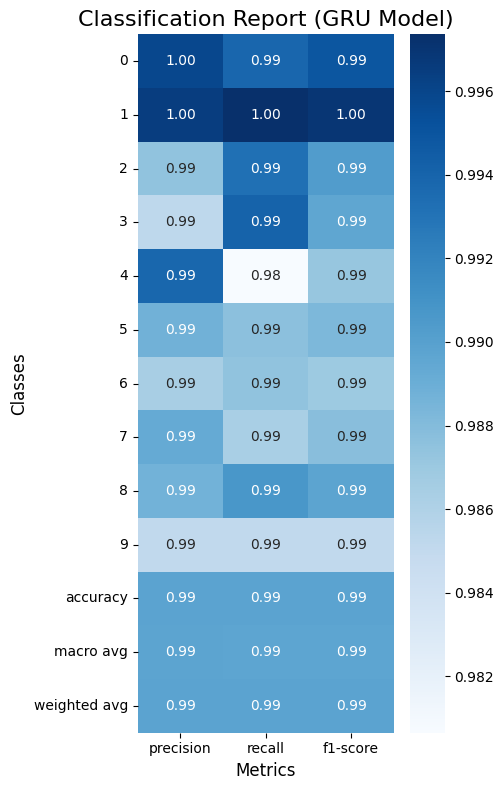

In [12]:
# Evaluate the GRU model
print("\nRunning evaluation on test data for GRU model...")
test_loss_gru, test_acc_gru = gru_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_gru:.4f}, Test Accuracy: {test_acc_gru:.4f}")

# Make predictions with GRU model
y_pred_gru = gru_model.predict(x_test)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_true_classes_gru = np.argmax(y_test, axis=1)

# Classification report for GRU model
report_gru = classification_report(y_true_classes_gru, y_pred_classes_gru, target_names=[str(i) for i in range(10)], output_dict=True)
df_gru = pd.DataFrame(report_gru)  #.transpose()
fig, ax = plt.subplots(figsize=(len(df_gru)+1, 8))
sns.heatmap(df_gru.iloc[:-1, :].T, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_title("Classification Report (GRU Model)", fontsize=16)
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Classes", fontsize=12)
plt.tight_layout()
# plt.savefig('examples/out/gru_classification_report.png')
plt.show()

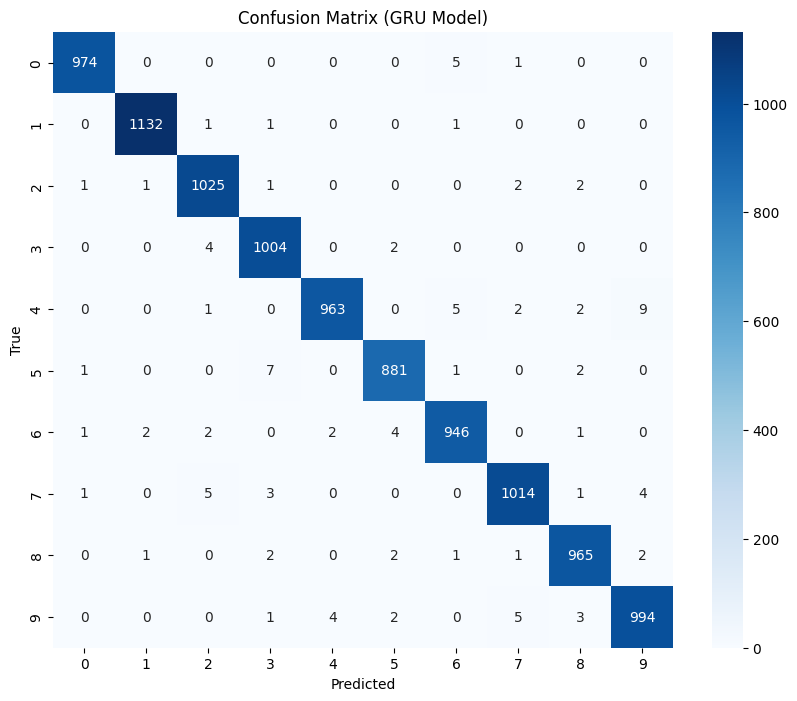

In [13]:
# Confusion matrix for GRU model
cm_gru = confusion_matrix(y_true_classes_gru, y_pred_classes_gru)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix (GRU Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('examples/out/gru_confusion_matrix.png')
plt.show()

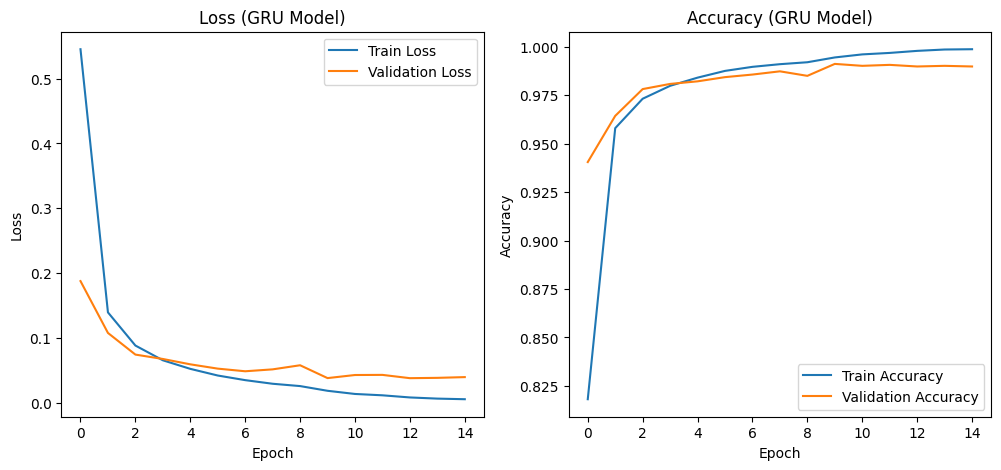

In [14]:
# Plot the training history for GRU model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Loss (GRU Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (GRU Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('examples/out/gru_training_history.png')
plt.show()

gru_model.save('examples/out/gru_model.h5')

## RNN

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 28, 128)        │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,098 (129.29 KB)

 Trainable params: 33,098 (129.29 KB)

 Non-trainable params: 0 (0.00 B)

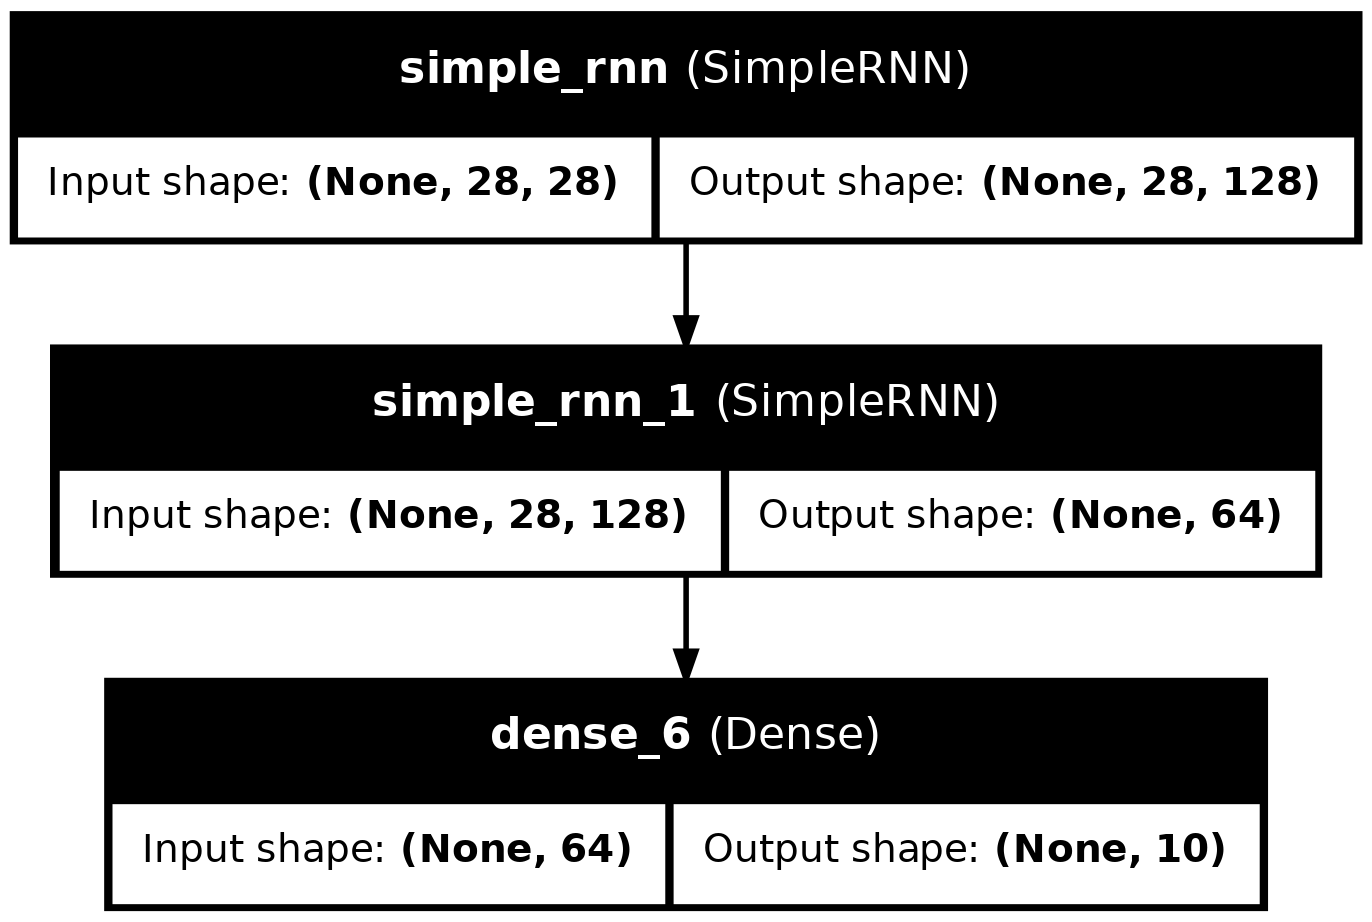

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Create a simple RNN model for comparison
rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(128, input_shape=(28, 28), return_sequences=True),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(10, activation='softmax')
])

# Compile and train the RNN model
rnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
rnn_model.summary()
plot_model(rnn_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/rnn_model.png')
Image(filename='examples/out/rnn_model.png', width=800)

In [16]:
# rnn_model = keras.models.load_model('examples/out/rnn_model.h5')

start_time = perf_time()
history_rnn = rnn_model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)
duration = perf_time() - start_time
print(f"Training time: {duration:.2f} seconds")

np.save('examples/out/rnn_history.npy', history_rnn.history)
# history_rnn = np.load('examples/out/rnn_history.npy', allow_pickle=True).item()

Epoch 1/15


2025-05-20 18:23:29.318532: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7934 - loss: 0.6909 - val_accuracy: 0.9387 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9443 - loss: 0.1901 - val_accuracy: 0.9573 - val_loss: 0.1520 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9564 - loss: 0.1466 - val_accuracy: 0.9642 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9650 - loss: 0.1194 - val_accuracy: 0.9603 - val_loss: 0.1413 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9667 - loss: 0.1097 - val_accuracy: 0.9603 - val_loss: 0.1433 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9763 - loss: 0.0810 - val_accuracy: 0.9778 - val_loss: 0.0850 - learning_rate: 5.0000e-04
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9809 - loss: 0.0678 - 


Running evaluation on test data for RNN model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9772 - loss: 0.0777
Test Loss: 0.0679, Test Accuracy: 0.9806
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


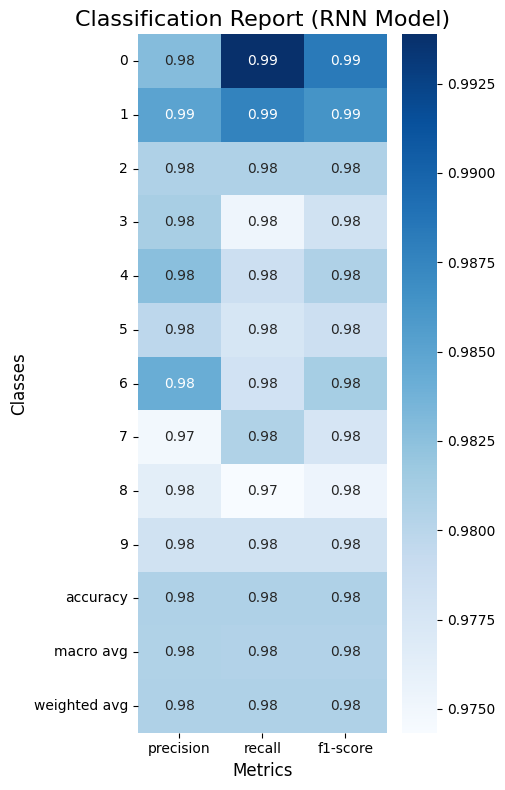

In [17]:
# Evaluate the RNN model
print("\nRunning evaluation on test data for RNN model...")
test_loss_rnn, test_acc_rnn = rnn_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_rnn:.4f}, Test Accuracy: {test_acc_rnn:.4f}")

# Make predictions with RNN model
y_pred_rnn = rnn_model.predict(x_test)
y_pred_classes_rnn = np.argmax(y_pred_rnn, axis=1)
y_true_classes_rnn = np.argmax(y_test, axis=1)

# Classification report for RNN model
report_rnn = classification_report(y_true_classes_rnn, y_pred_classes_rnn, target_names=[str(i) for i in range(10)], output_dict=True)
df_rnn = pd.DataFrame(report_rnn)  #.transpose()
fig, ax = plt.subplots(figsize=(len(df_rnn)+1, 8))
sns.heatmap(df_rnn.iloc[:-1, :].T, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_title("Classification Report (RNN Model)", fontsize=16)
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Classes", fontsize=12)
plt.tight_layout()
# plt.savefig('examples/out/rnn_classification_report.png')
plt.show()

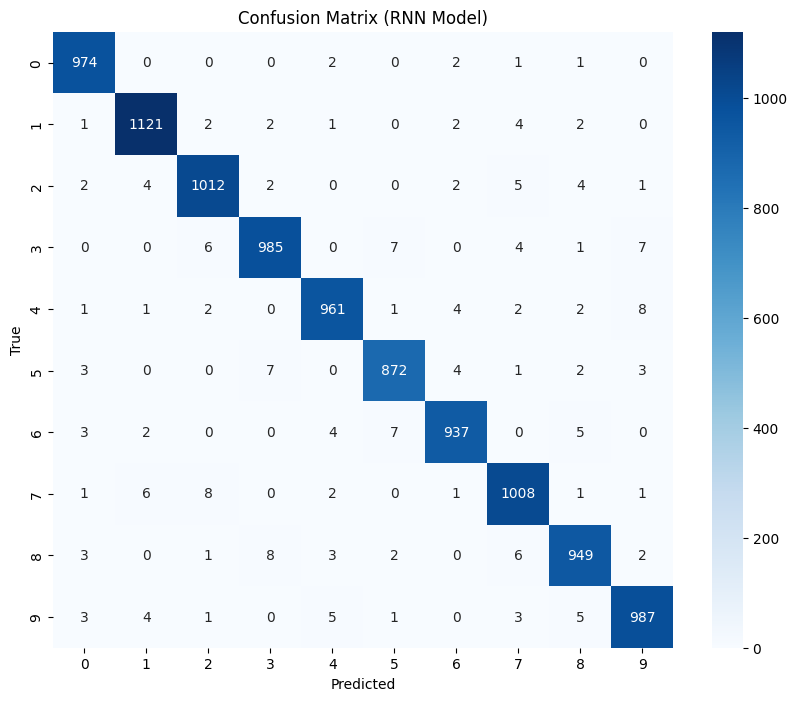

In [18]:
# Confusion matrix for RNN model
cm_rnn = confusion_matrix(y_true_classes_rnn, y_pred_classes_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix (RNN Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('examples/out/rnn_confusion_matrix.png')
plt.show()

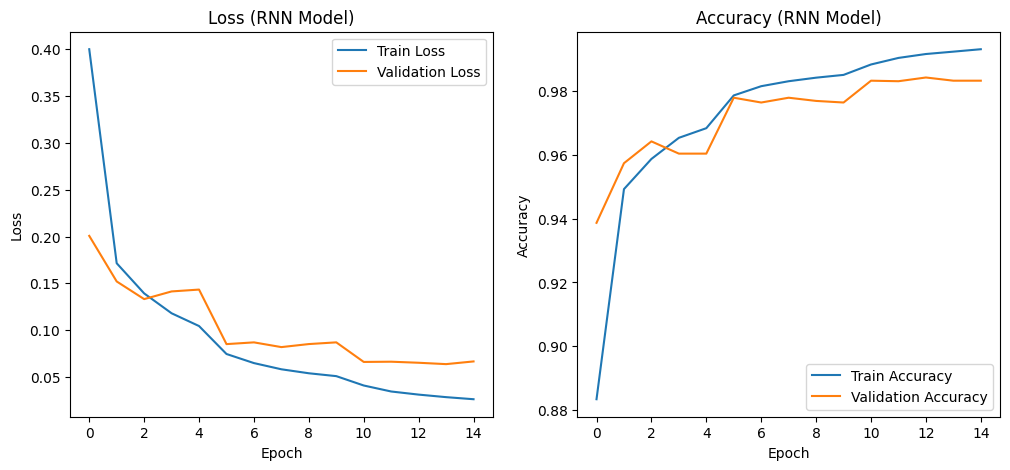

In [19]:
# Plot the training history for RNN model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss (RNN Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (RNN Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('examples/out/rnn_training_history.png')
plt.show()

rnn_model.save('examples/out/rnn_model.h5')

## LSTM

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 28, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,442 (509.54 KB)

 Trainable params: 130,442 (509.54 KB)

 Non-trainable params: 0 (0.00 B)

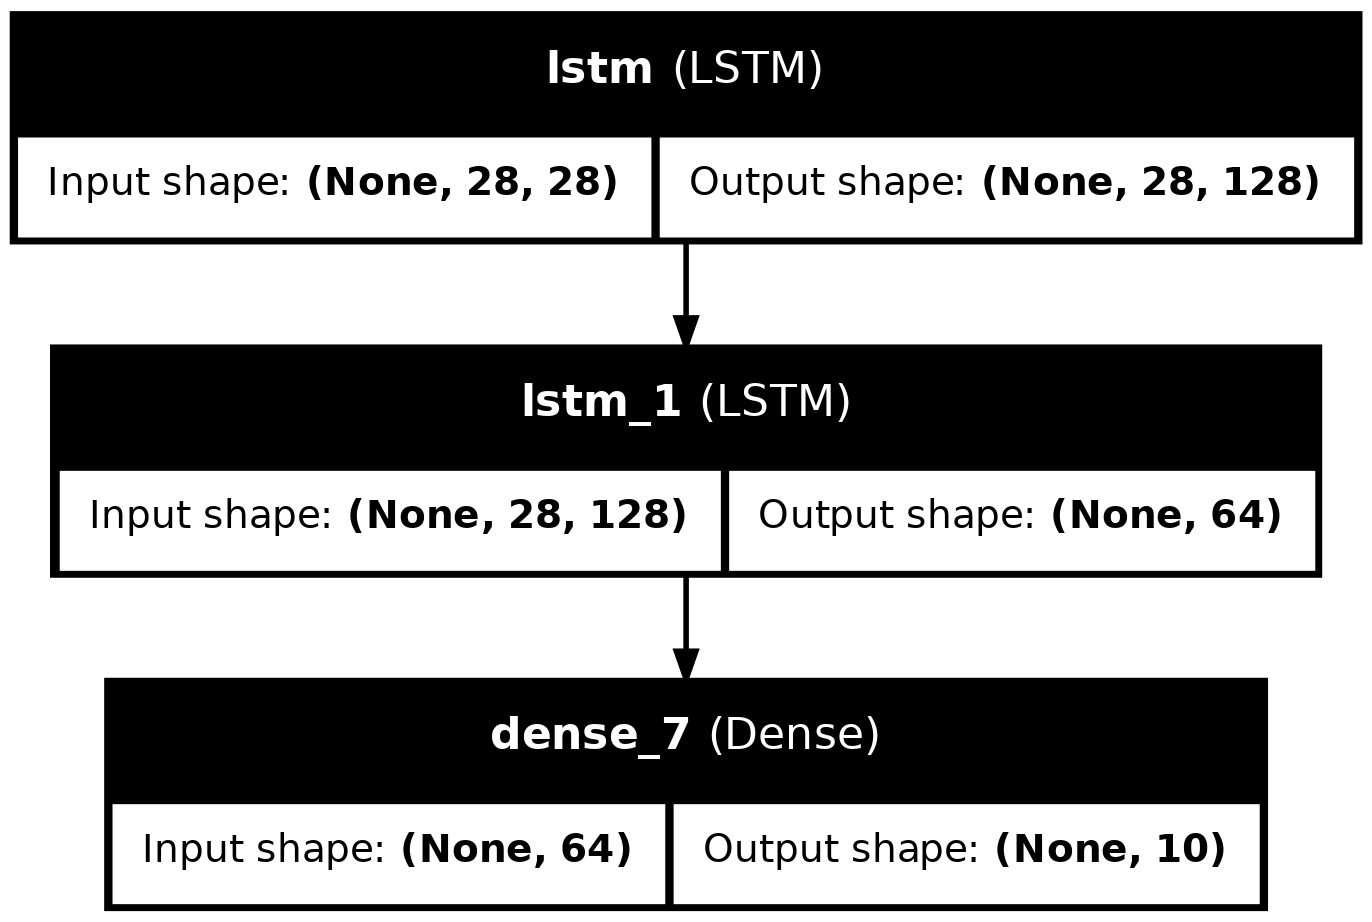

In [20]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Create an LSTM model for comparison
lstm_model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(28, 28), return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(10, activation='softmax')
])

# Compile and train the LSTM model
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
lstm_model.summary()
plot_model(lstm_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/lstm_model.png')
Image(filename='examples/out/lstm_model.png', width=800)

In [21]:
# lstm_model = keras.models.load_model('examples/out/lstm_model.h5')

start_time = perf_time()
history_lstm = lstm_model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)
duration = perf_time() - start_time
print(f"Training time: {duration:.2f} seconds")

np.save('examples/out/lstm_history.npy', history_lstm.history)
# history_lstm = np.load('examples/out/lstm_history.npy', allow_pickle=True).item()

Epoch 1/15


2025-05-20 18:25:07.108661: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.6719 - loss: 0.9857 - val_accuracy: 0.9473 - val_loss: 0.1799 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9497 - loss: 0.1708 - val_accuracy: 0.9660 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9689 - loss: 0.1062 - val_accuracy: 0.9738 - val_loss: 0.0880 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9778 - loss: 0.0749 - val_accuracy: 0.9765 - val_loss: 0.0807 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9824 - loss: 0.0583 - val_accuracy: 0.9798 - val_loss: 0.0698 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9861 - loss: 0.0463 - val_accuracy: 0.9832 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9890 - loss: 0.0368


Running evaluation on test data for LSTM model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9868 - loss: 0.0467
Test Loss: 0.0385, Test Accuracy: 0.9890
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


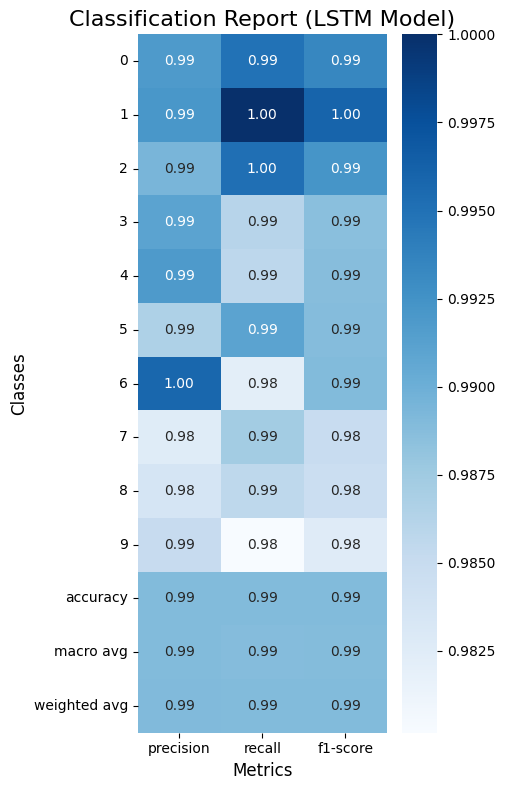

In [22]:
# Evaluate the LSTM model
print("\nRunning evaluation on test data for LSTM model...")
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss_lstm:.4f}, Test Accuracy: {test_acc_lstm:.4f}")

# Make predictions with LSTM model
y_pred_lstm = lstm_model.predict(x_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_true_classes_lstm = np.argmax(y_test, axis=1)

# Classification report for LSTM model
report_lstm = classification_report(y_true_classes_lstm, y_pred_classes_lstm, target_names=[str(i) for i in range(10)], output_dict=True)
df_lstm = pd.DataFrame(report_lstm)  #.transpose()
fig, ax = plt.subplots(figsize=(len(df_lstm)+1, 8))
sns.heatmap(df_lstm.iloc[:-1, :].T, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_title("Classification Report (LSTM Model)", fontsize=16)
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Classes", fontsize=12)
plt.tight_layout()
# plt.savefig('examples/out/lstm_classification_report.png')
plt.show()

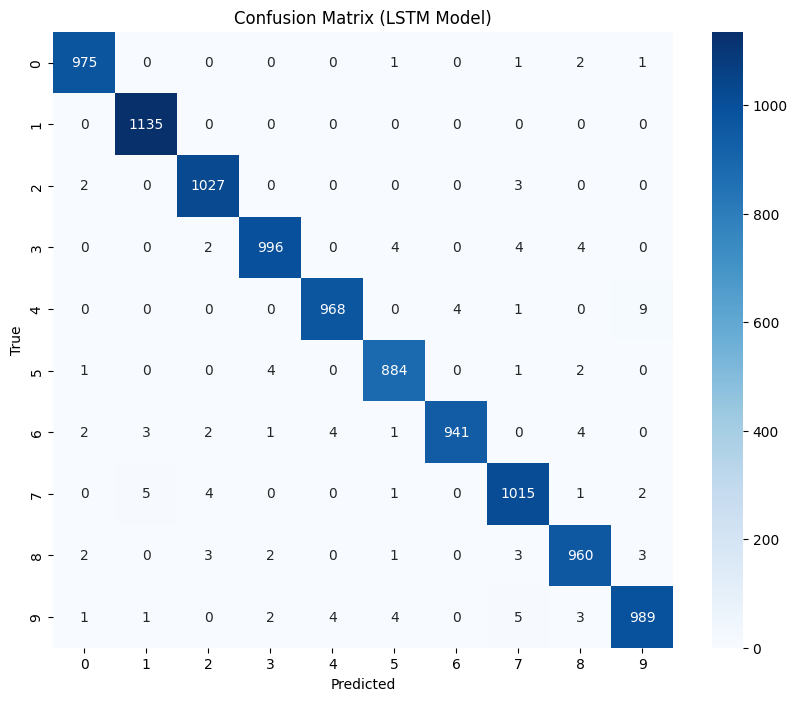

In [23]:
# Confusion matrix for LSTM model
cm_lstm = confusion_matrix(y_true_classes_lstm, y_pred_classes_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix (LSTM Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('examples/out/lstm_confusion_matrix.png')
plt.show()

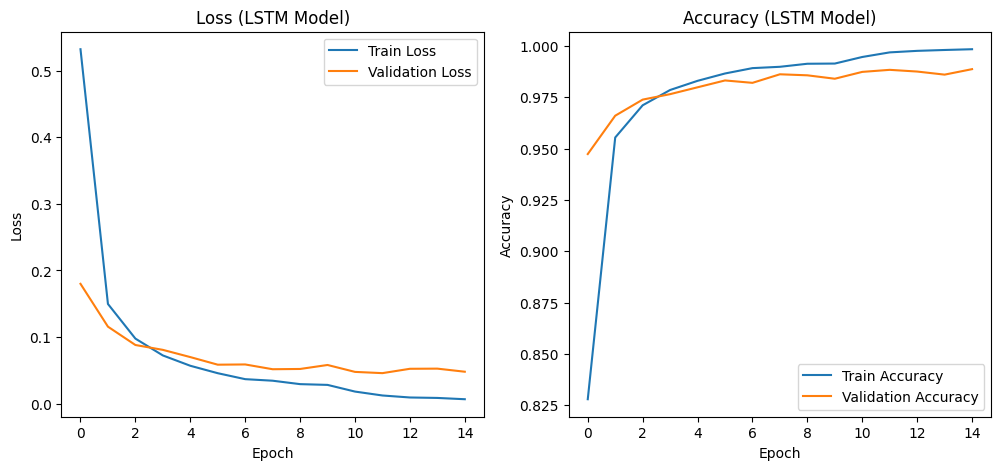

In [24]:
# Plot the training history for LSTM model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss (LSTM Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (LSTM Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('examples/out/lstm_training_history.png')
plt.show()

lstm_model.save('examples/out/lstm_model.h5')

# Comparison Analysis

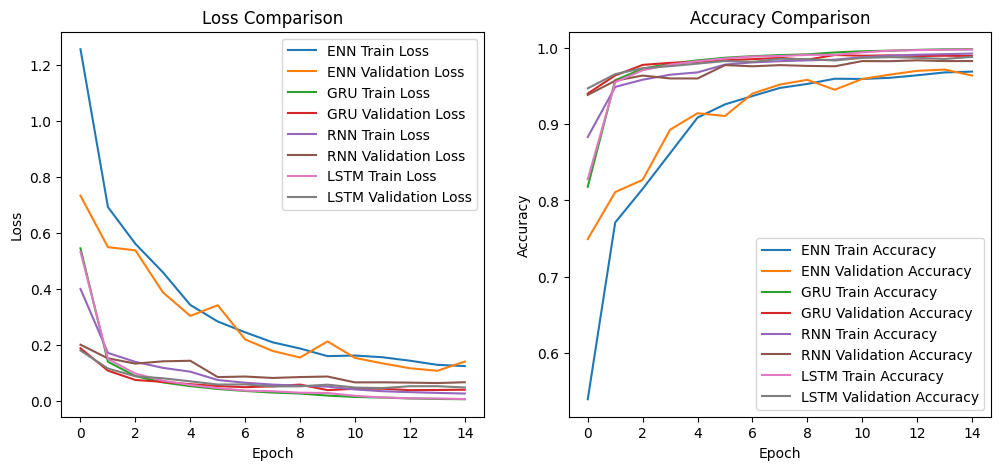

In [25]:
# Compare all four models - ENN, GRU, RNN, LSTM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='ENN Train Loss')
plt.plot(history.history['val_loss'], label='ENN Validation Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss')
plt.plot(history_rnn.history['loss'], label='RNN Train Loss')
plt.plot(history_rnn.history['val_loss'], label='RNN Validation Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='ENN Train Accuracy')
plt.plot(history.history['val_accuracy'], label='ENN Validation Accuracy')
plt.plot(history_gru.history['accuracy'], label='GRU Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='GRU Validation Accuracy')
plt.plot(history_rnn.history['accuracy'], label='RNN Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation Accuracy')
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('examples/out/model_comparison.png')
plt.show()

## Experimental Analysis

### Hypotheses

#### 1. ANOVA for Test Accuracy
- **Null Hypothesis (H₀)**: The mean test accuracy of the `ENN` model is not significantly different from the mean test accuracy of the other models (`GRU`, `RNN`, `LSTM`).
- **Alternative Hypothesis (H₁)**: The mean test accuracy of the `ENN` model is significantly different from the mean test accuracy of at least one of the other models.

#### 2. Kruskal-Wallis Test for Test Loss
- **Null Hypothesis (H₀)**: The distribution of test loss for the `ENN` model is not significantly different from the distribution of test loss for the other models (`GRU`, `RNN`, `LSTM`).
- **Alternative Hypothesis (H₁)**: The distribution of test loss for the `ENN` model is significantly different from the distribution of test loss for at least one of the other models.

#### 3. Post-Hoc Analysis (Tukey's HSD)
- If the ANOVA test is significant, the post-hoc test will identify whether the `ENN` model has significantly different mean test accuracy compared to specific other models (`GRU`, `RNN`, `LSTM`).

  Model  Test Loss  Test Accuracy
0   ENN     0.1405         0.9642
1   ENN     0.1287         0.9682
2   GRU     0.0399         0.9898
3   GRU     0.0368         0.9898
4   RNN     0.0665         0.9832
5   RNN     0.0679         0.9806
6  LSTM     0.0478         0.9887
7  LSTM     0.0385         0.9890 

ANOVA result: F-statistic = 83.33114514952777, p-value = 0.0004625765734560688
Kruskal-Wallis result: H-statistic = 6.166666666666664, p-value = 0.10377716386905098
ANOVA is significant, performing post-hoc tests...

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ENN    GRU   0.0236 0.0005  0.0167  0.0305   True
   ENN   LSTM   0.0227 0.0006  0.0158  0.0295   True
   ENN    RNN   0.0157 0.0026  0.0088  0.0226   True
   GRU   LSTM   -0.001 0.9384 -0.0078  0.0059  False
   GRU    RNN  -0.0079 0.0317 -0.0148  -0.001   True
  LSTM    RNN   -0.007 0.0484 -0.0138 -0.0001   Tru

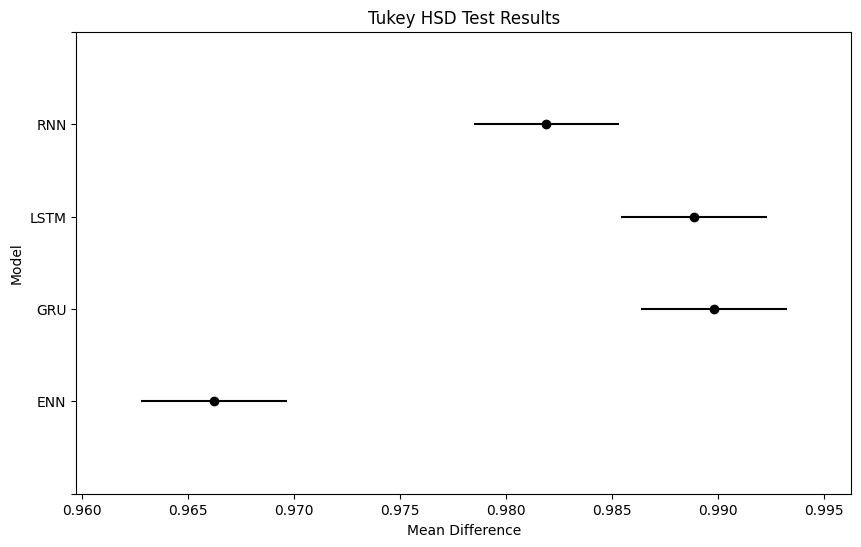

In [39]:
# Statistical analysis comparing model performances
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df = pd.DataFrame({
    'Model':         ['ENN',  'ENN',  'GRU',  'GRU',  'RNN',  'RNN',  'LSTM', 'LSTM'],
    'Test Loss':     [0.1405, 0.1287, 0.0399, 0.0368, 0.0665, 0.0679, 0.0478, 0.0385],
    'Test Accuracy': [0.9642, 0.9682, 0.9898, 0.9898, 0.9832, 0.9806, 0.9887, 0.9890]
})
df['Model'] = df['Model'].astype('category')
df['Model'] = df['Model'].cat.set_categories(['ENN', 'GRU', 'RNN', 'LSTM'])
df['Test Loss'] = df['Test Loss'].astype(float)
df['Test Accuracy'] = df['Test Accuracy'].astype(float)

print(df, '\n')

# Perform ANOVA
anova_result = f_oneway(
    df[df['Model'] == 'ENN']['Test Accuracy'],
    df[df['Model'] == 'GRU']['Test Accuracy'],
    df[df['Model'] == 'RNN']['Test Accuracy'],
    df[df['Model'] == 'LSTM']['Test Accuracy']
)
print(f"ANOVA result: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")


kruskal_result = kruskal(
    df[df['Model'] == 'ENN']['Test Loss'],
    df[df['Model'] == 'GRU']['Test Loss'],
    df[df['Model'] == 'RNN']['Test Loss'],
    df[df['Model'] == 'LSTM']['Test Loss']
)
print(f"Kruskal-Wallis result: H-statistic = {kruskal_result.statistic}, p-value = {kruskal_result.pvalue}")

# If ANOVA is significant, perform post-hoc tests
if anova_result.pvalue < 0.05:
    print("ANOVA is significant, performing post-hoc tests...\n")
    tukey_result = pairwise_tukeyhsd(df['Test Accuracy'], df['Model'])
    print(tukey_result)
    tukey_result.plot_simultaneous()
    plt.title('Tukey HSD Test Results')
    plt.xlabel('Mean Difference')
    plt.ylabel('Model')
    # plt.savefig('examples/out/tukey_hsd_results.png')
    plt.show()
else:
    print("ANOVA is not significant, no post-hoc tests needed.")

# Save the DataFrame to a CSV file
df.to_csv('examples/out/model_comparison.csv', index=False)

### Results
The statistical analysis comparing the performance of the `ENN` model against the other architectures (`GRU`, `RNN`, `LSTM`) yielded the following results:

#### Summary of Model Performance
| Model       | Test Loss | Test Accuracy |
|-------------|-----------|---------------|
| ENN (val)   | 0.1405    | 0.9642        |
| ENN (test)  | 0.1287    | 0.9682        |
| GRU (val)   | 0.0399    | 0.9898        |
| GRU (test)  | 0.0368    | 0.9898        |
| RNN (val)   | 0.0665    | 0.9832        |
| RNN (test)  | 0.0679    | 0.9806        |
| LSTM (val)  | 0.0478    | 0.9887        |
| LSTM (test) | 0.0385    | 0.9890        |

#### 1. ANOVA for Test Accuracy
- **F-statistic**: 83.33
- **p-value**: 0.00046
- The ANOVA test indicates a significant difference in test accuracy between the `ENN` model and at least one of the other models.

#### 2. Kruskal-Wallis Test for Test Loss
- **H-statistic**: 6.17
- **p-value**: 0.1038
- The Kruskal-Wallis test suggests no significant difference in test loss between the `ENN` model and the other models.

#### 3. Tukey's HSD Post-Hoc Analysis
The post-hoc analysis was conducted due to the significant ANOVA result. The pairwise comparisons are as follows:
| Group 1 | Group 2 | Mean Difference | p-value | Reject Null Hypothesis |
|---------|---------|-----------------|---------|------------------------|
| ENN     | GRU     | 0.0236          | 0.0005  | True                   |
| ENN     | LSTM    | 0.0227          | 0.0006  | True                   |
| ENN     | RNN     | 0.0157          | 0.0026  | True                   |
| GRU     | LSTM    | -0.001          | 0.9384  | False                  |
| GRU     | RNN     | -0.0079         | 0.0317  | True                   |
| LSTM    | RNN     | -0.007          | 0.0484  | True                   |

#### Conclusions
1. The ANOVA test revealed significant differences in test accuracy between the `ENN` model and the other architectures. While `GRU` and `LSTM` achieved the highest accuracy, the `ENN` model demonstrated competitive performance with only a subtle difference in accuracy compared to these models. The mean test accuracy of `ENN` was within approximately 2.5% of the top-performing models, which is a promising result given the simplicity and novelty of the architecture.
2. The Kruskal-Wallis test did not find significant differences in test loss, indicating that the `ENN` model performed similarly to the other architectures in minimizing loss.
3. Tukey's HSD post-hoc analysis identified specific pairwise differences in test accuracy. Notably, the `ENN` model showed statistically significant differences compared to `GRU` and `LSTM`, but these differences were relatively small in magnitude. This suggests that the ENN model is a viable alternative for tasks requiring efficient memory management and interpretability.

Overall, the `ENN` model demonstrates strong potential and is competitive with established architectures like `GRU`, `RNN`, and `LSTM`. Its unique characteristics, including Hebbian learning, sparsity regularization, and biologically-inspired design, make it particularly beneficial in sequence modeling and memory-intensive applications. Furthermore, the ability to record and visualize Hebbian traces provides a significant advantage in terms of interpretability. By examining the initial and final traces, as well as their evolution, users can gain insights into how the model learns and adapts over time. This makes the ENN model less of a "black box" and allows for better debugging, optimization, and understanding of memory dynamics. For example, the trace evolution can reveal whether the model is effectively capturing long-term dependencies or struggling with specific data patterns. Further optimization and exploration of its hyperparameters could narrow the performance gap even further, allowing the model to be even more competative to the state-of-the-art architectures.


<hr/>

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ engram_2 (Engram)               │ (None, 128)            │       226,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,722 (889.54 KB)

 Trainable params: 219,530 (857.54 KB)

 Non-trainable params: 8,192 (32.00 KB)

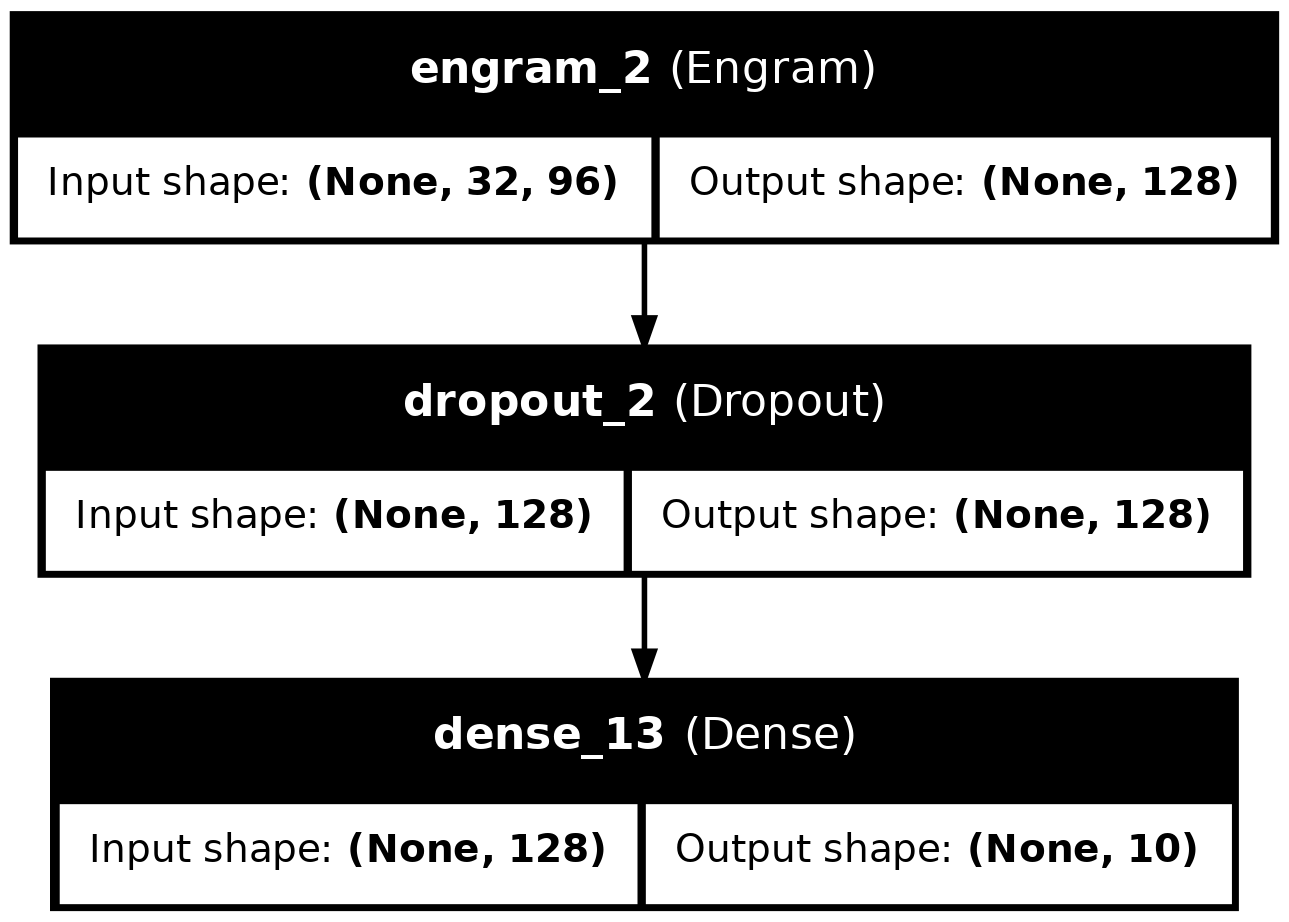

In [ ]:
# Test the model with a much larger, heavier dataset
# Load the CIFAR-10 dataset
from keras.datasets import cifar10
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

# Normalize the data
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0

# Reshape the data to fit the model
x_train_cifar = x_train_cifar.reshape(-1, 32, 96).astype(np.float32)  # 32 time steps, 96 features
x_test_cifar = x_test_cifar.reshape(-1, 32, 96).astype(np.float32)

# Apply scaler for additional normalization
scaler_cifar = MinMaxScaler()

# Create the model
cifar_model = engram_classifier(
    input_shape=(32, 96),  # 32 time steps, each with 96 features
    hidden_dim=128,
    memory_size=64,  # Increased memory size
    num_classes=10,
    return_states=True,
    hebbian_lr=0.05  # Higher learning rate for Hebbian updates
)

trace_callback = HebbianTraceMonitor(
    x_train[:32], 
    log_dir="examples/out/hebbian_trace", 
    verbose=1, 
    plot_every=100, 
    skip_first_plot=True
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Compile and train the model
cifar_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cifar_model.summary()

plot_model(cifar_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/cifar_model.png')
Image(filename='examples/out/cifar_model.png', width=800)
# cifar_model = keras.models.load_model('examples/out/cifar_model.h5', custom_objects={'HebbianTraceMonitor': HebbianTraceMonitor, 'Engram': Engram})

In [ ]:
# Train the model
start_time = perf_time()
history_cifar = cifar_model.fit(
    x_train_cifar, y_train_cifar,
    batch_size=128,
    epochs=50,
    validation_data=(x_test_cifar, y_test_cifar),
    callbacks=[trace_callback, early_stopping, lr_scheduler],
    verbose=1
)
duration = perf_time() - start_time
print(f"Training time: {duration:.2f} seconds")

np.save('examples/out/cifar_history.npy', history_cifar.history)
# history_cifar = np.load('examples/out/cifar_history.npy', allow_pickle=True).item()

Epoch 1/30


2025-05-20 19:51:14.777863: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


391/391 ━━━━━━━━━━━━━━━━━━━━ 66s 161ms/step - accuracy: 0.1732 - loss: 2.3218 - val_accuracy: 0.2647 - val_loss: 2.0024 - learning_rate: 0.0010
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.2601 - loss: 1.9973 - val_accuracy: 0.2873 - val_loss: 1.8870 - learning_rate: 0.0010
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 138ms/step - accuracy: 0.2903 - loss: 1.9110 - val_accuracy: 0.2735 - val_loss: 1.9508 - learning_rate: 0.0010
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - accuracy: 0.3019 - loss: 1.8759 - val_accuracy: 0.2720 - val_loss: 1.9406 - learning_rate: 0.0010
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.3280 - loss: 1.7867 - val_accuracy: 0.3467 - val_loss: 1.7410 - learning_rate: 5.0000e-04
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 139ms/step - accuracy: 0.3537 - loss: 1.7284 - val_accuracy: 0.3603 - val_loss: 1.6989 - learning_rate: 5.0000e-04
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 139ms/step - accuracy: 0.3635

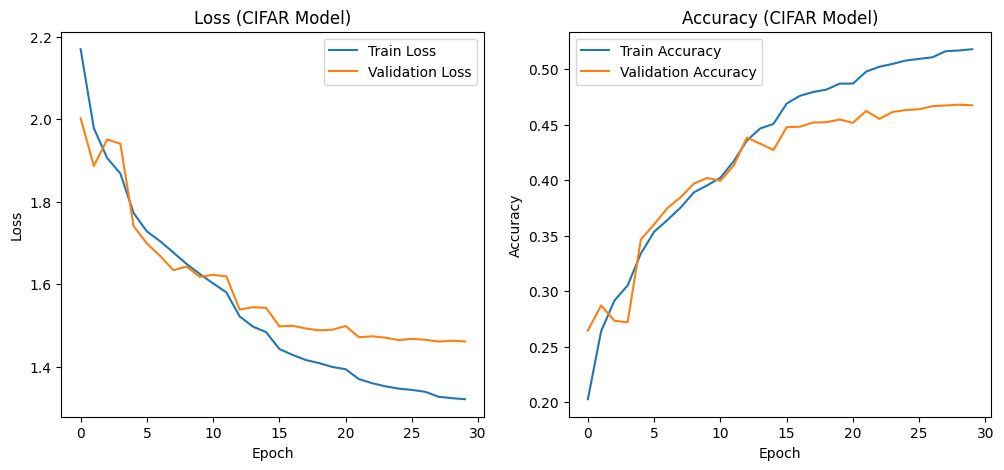

In [43]:
# Plot the training history for GRU model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cifar.history['loss'], label='Train Loss')
plt.plot(history_cifar.history['val_loss'], label='Validation Loss')
plt.title('Loss (CIFAR Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_cifar.history['accuracy'], label='Train Accuracy')
plt.plot(history_cifar.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (CIFAR Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('examples/out/cifar_training_history.png')
plt.show()

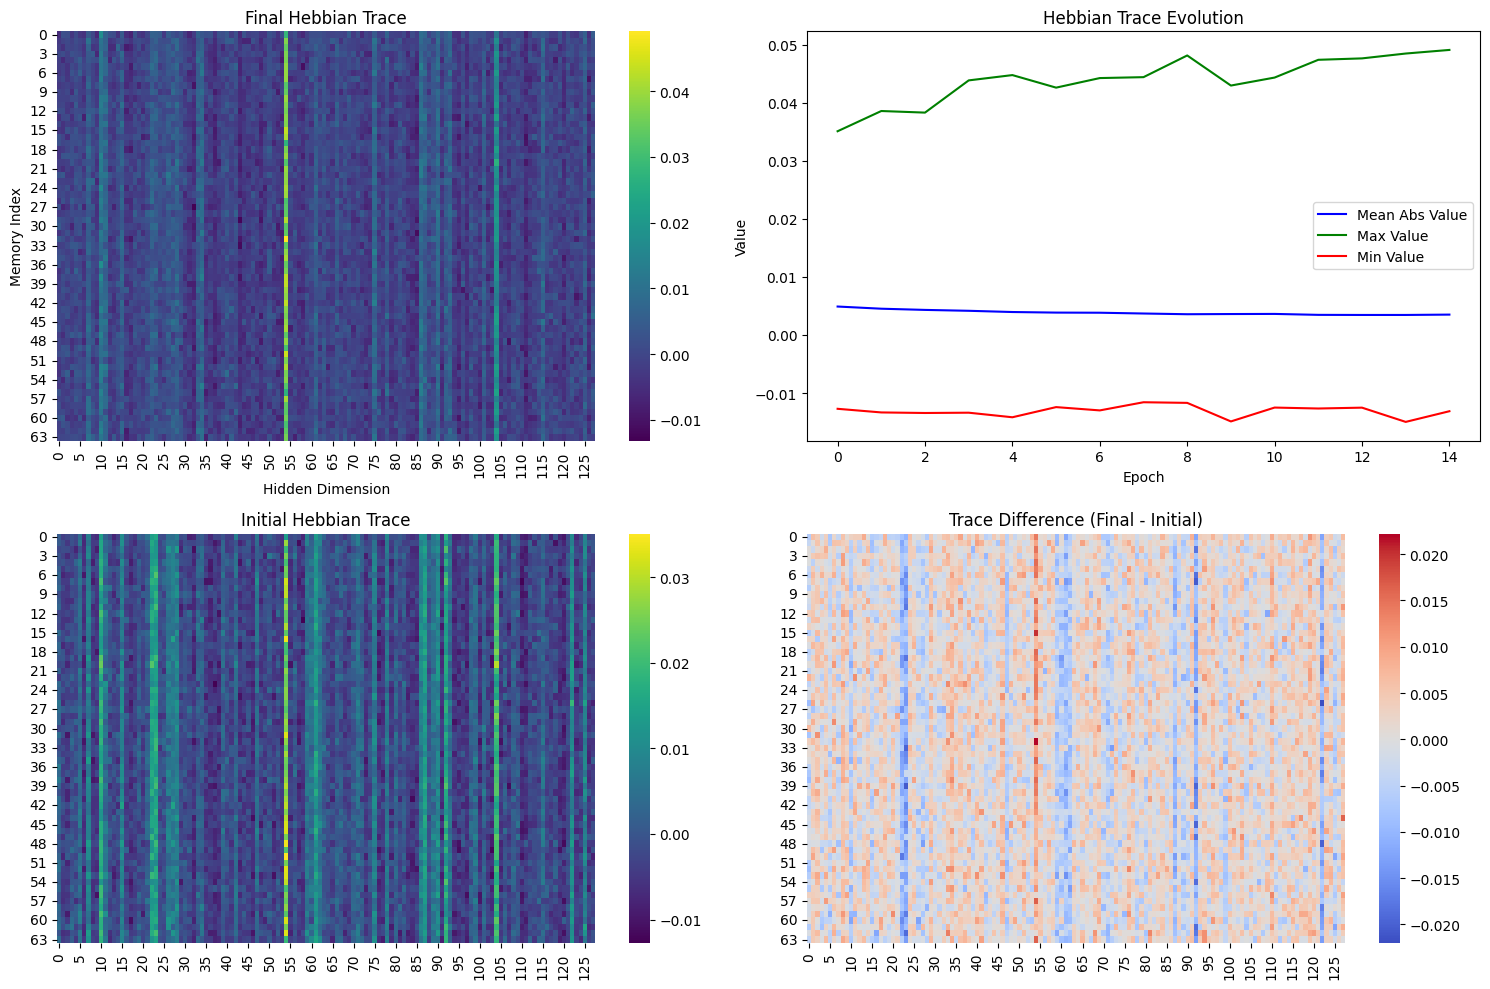

In [44]:
plot_hebbian_trace(trace_callback)